# Amazon Review - Distributions For All Downsampled Dataset

Since we are having issues with deep learning model performance, I want to make sure the various datasets we are using have the same distribution as the same dataset.

We will look at the following for our various downsampled datasets:
* star rating distribution
* review body length


# Conclusion

For all data sets, star rating distribution as well as review body length look roughly the same. No bias was introduced in our down-sampling method.



In [1]:
# import sibling utilities
import sys
sys.path.append('../..')

import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=2)
import logging

logging.basicConfig(level=logging.INFO)

import util.file_util as fu

import sys,os,os.path
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

# global variables
COLUMNS_TO_DROP=["marketplace", "vine", "verified_purchase"]
USE_PANDAS=True
SEPERATOR=","

DATA_DIR = "../../dataset/amazon_reviews"

DEBUG = False

# Read in our pre-processed File

In [2]:
DATA_FILE_TEST=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv"
DATA_FILE_50k=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-50k-preprocessed.csv"
DATA_FILE_100k=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-100k-preprocessed.csv"
DATA_FILE_200k=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-200k-preprocessed.csv"
DATA_FILE_500k=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-500k-preprocessed.csv"
DATA_FILE_1m=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-1m-preprocessed.csv"
DATA_FILE_2m=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-2m-preprocessed.csv"
DATA_FILE_4m=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-4m-preprocessed.csv"
DATA_FILE_ALL=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-all-preprocessed.csv"


if DEBUG:
#     DATA_FILES = [DATA_FILE_TEST, DATA_FILE_50k, DATA_FILE_100k, DATA_FILE_200k]
    DATA_FILES = [DATA_FILE_TEST, DATA_FILE_50k, DATA_FILE_TEST, DATA_FILE_50k]
else:
    DATA_FILES = [DATA_FILE_200k, DATA_FILE_500k, DATA_FILE_1m, DATA_FILE_2m, DATA_FILE_4m, DATA_FILE_ALL]


# Load Data File(s)

Load all data files into data frames, then store them in an array so we can do the same processing for them later

In [3]:
# this will hold all of our files
reviews = []

for file in DATA_FILES:
    data = pd.read_csv(file, sep=SEPERATOR, 
                         parse_dates=["review_date"])
    reviews.append(data)

len(reviews)

6

In [4]:
reviews[0].columns

Index(['star_rating', 'helpful_votes', 'total_votes', 'review_headline',
       'review_body', 'review_date'],
      dtype='object')

## Star Rating Distribution



In [5]:
# Put all of our distributions on the same percentage scale
all_ratings = []

for data in reviews:
    # put our distribution on the same scale
    ratings = pd.DataFrame(data.groupby("star_rating").size()).rename({0: "total"}, axis=1).reset_index()
    ratings["star_rating_percentage"] = ratings.total / len(data)
    all_ratings.append(ratings)


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


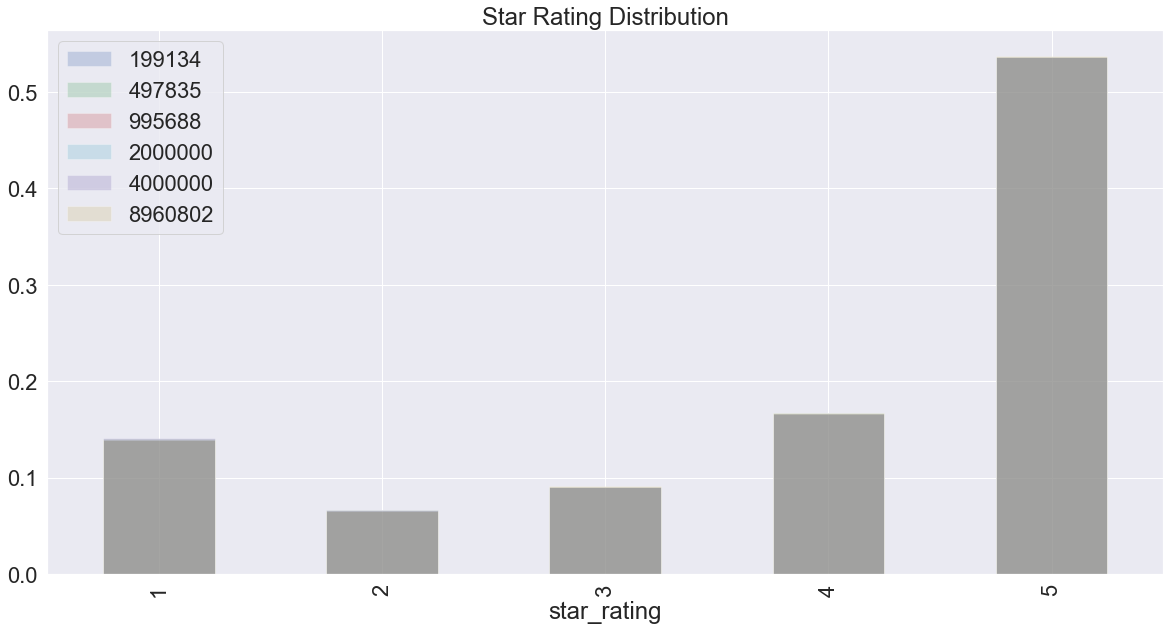

In [6]:
# plot all distributions onto one graph

f, a = plt.subplots(1, 1, figsize=(20, 10))

colors = ["b", "g", "r", "c", "m", "y", "k"]
index = 0
for data in reversed(all_ratings):
    # put our distribution on the same scale
    _ = data.plot(x="star_rating", 
                     y = "star_rating_percentage", 
                     kind="bar",
                     sharey = True, 
                     alpha = 0.25,
                     ax=a,
                     color = colors[index],
                     label = len(reviews[index]))
    index += 1

_ = a.set_title("Star Rating Distribution")

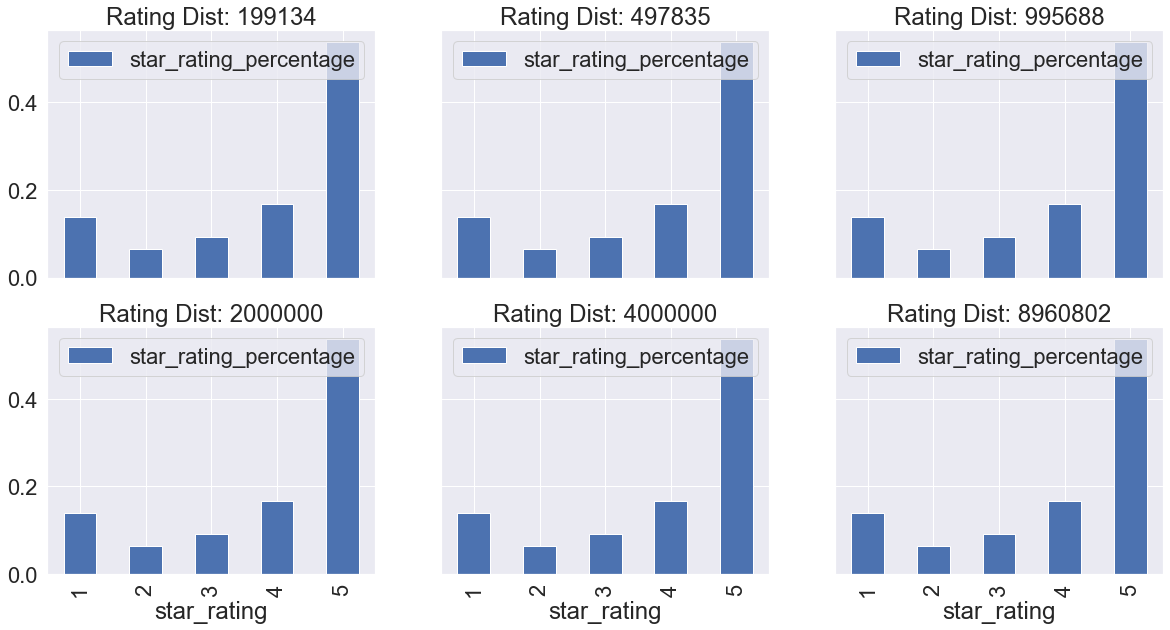

In [7]:
# plot all distributions in a grid view - we will plot them in a 3x3 grid

cols = 3
rows = len(reviews) // 3
# print(f'rows {rows} cols {cols}')

f, a = plt.subplots(rows, cols, figsize=(20, 5*rows))


index = 0
row = 0
col = 0
for ratings in all_ratings:
#     print(f'row {row} col {col}')
    
    # axis 2D array if we have more than 1 row but regular array if there is less than 1 row
    if rows > 1:
        ax = a[row][col]
    else:
        ax = a[col]

    _ = data.plot(x="star_rating", 
                 y = "star_rating_percentage", 
                 kind="bar",
                 sharey = True, 
                  sharex = True,
#                  color = colors[index],
#                   label = len(reviews[index]),
                 ax = ax
                 )
    _ = ax.set_title(f'Rating Dist: {len(reviews[index])}')
    
    index += 1
    if index % 3 == 0:
        row += 1
        col = 0
    else:
        col += 1




# Review Body Word Count Distribution

We are going to check to make sure the word count for our review bodies roughly look the same across our datasets

In [8]:
# get the word count for our reviews and bin them
for data in reviews:
#     print(len(data))
    data["review_wc"] = data.review_body.apply(lambda x: len(str(x).split()))
    data["wc_bin"] = pd.cut(data.review_wc, 
       bins=[0, 10, 20, 40, 100, reviews[0].review_wc.max()],
      labels=["0-10", "10-20", "20-40", "40-100", ">100"])
#     print(data.columns)

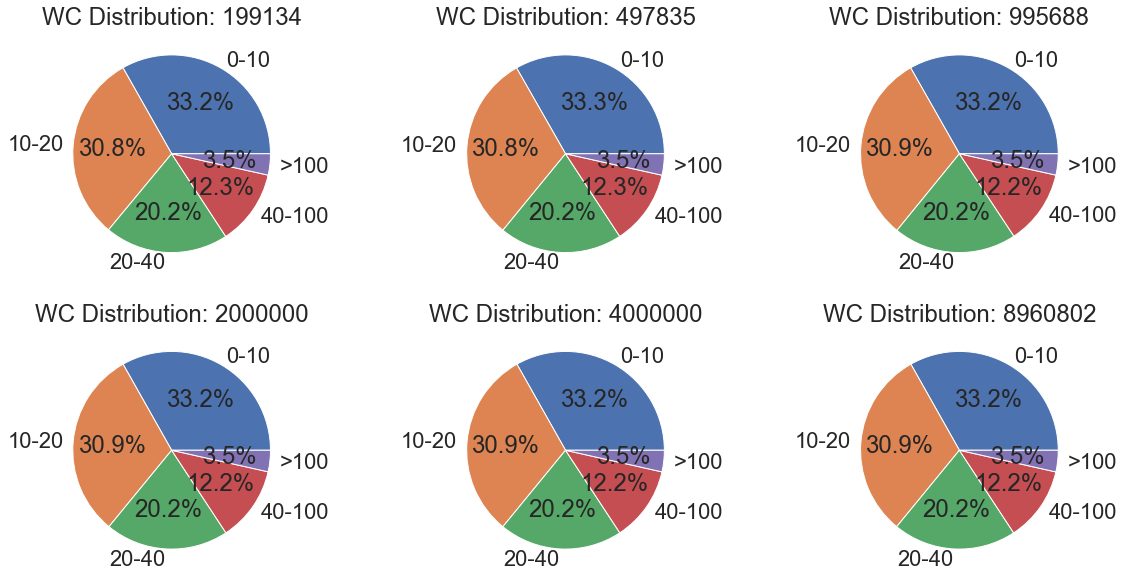

In [9]:
# plot all word count bins in a grid view - we will plot them in a 3x3 grid

cols = 3
rows = len(reviews) // 3
# print(f'rows {rows} cols {cols}')

f, a = plt.subplots(rows, cols, figsize=(20, 5*rows))


index = 0
row = 0
col = 0
for review in reviews:
#     print(f'row {row} col {col}')
#     print(review.columns)
    
    wc_bins = review.groupby("wc_bin").count().reset_index()
    wc_bins["bin_percentage"] = wc_bins.review_wc / wc_bins.review_wc.sum()

    
    # axis 2D array if we have more than 1 row but regular array if there is less than 1 row
    if rows > 1:
        ax = a[row][col]
    else:
        ax = a[col]

        
    _ = ax.pie(wc_bins.bin_percentage, 
               labels=wc_bins.wc_bin, 
               autopct='%1.1f%%',
                )
    _ = ax.set_title(f'WC Distribution: {len(reviews[index])}')

    index += 1
    if index % 3 == 0:
        row += 1
        col = 0
    else:
        col += 1




In [10]:
print(datetime.now())

2020-02-06 19:59:30.023314
